In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 26.5 MB 49 kB/s             
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=814a5354110429b8fabcd24e44d785cace6c4f17e689b22047b1f4f060608d50
  Stored in directory: /home/roman/.cache/pip/wheels/9b/13/01/6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn


In [25]:
#Load first project
import random
import spacy
import re
import sklearn
import seaborn as sns

nlp = spacy.load("en_core_web_sm")

STOPWORDS = nlp.Defaults.stop_words

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

df = pd.concat([train_data, test_data])

TRAIN_SIZE = len(df)
SEN = df.text.iloc[0]

df.head()

len_train = len(train_data)

ModuleNotFoundError: No module named 'sklearn'

In [11]:
df.target.value_counts()

0.0    4342
1.0    3271
Name: target, dtype: int64

In [12]:
df.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [13]:
df.fillna(" Unknown", inplace=True)

In [14]:
uniq_keyword = df.keyword.unique()
print(uniq_keyword)

[' Unknown' 'ablaze' 'accident' 'aftershock' 'airplane%20accident'
 'ambulance' 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army'
 'arson' 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'disaster' 'displaced'

/home/roman/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


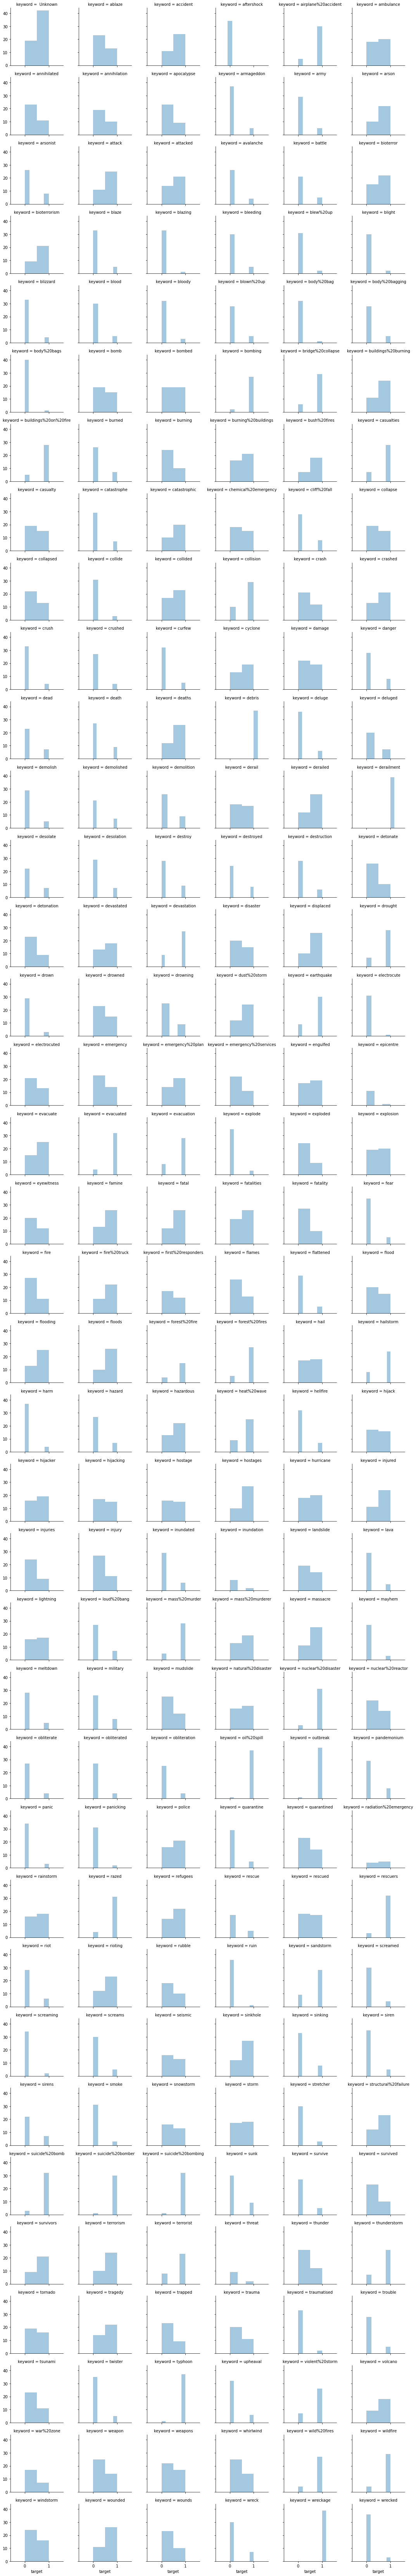

In [15]:
# Check the influence by keyword field

g = sns.FacetGrid(df[['keyword','target']].iloc[:len_train], col='keyword',height=2.5, col_wrap=6)
g.map(sns.distplot, 'target',kde=False)

### I can make the conclusion that some keywords have great influence, some not

## My plan

* Preprocess my df(clear, tokenize, create vocab, vectorizing)
* Choose a model
* Fit, predict, get score 

In [ ]:
#1step:  prepare text

In [16]:
def get_random_sen(data, num=1):
    
    """
    Generate random examples of sentences
    
    data: pandas series with text
    num: number of examples
    """
    
    size = len(data)
    
    for i in range(num):
        return str(data.iloc[random.randint(0, size)])
        

In [17]:
def create_remove_list(data, punkt=True, at_name=True, hashtag=False, mail=True, stopwords=True, url=True, remove_list=[]):
    
    """
    Remove not require information from sentence
    
    Return str: list of words 
    """
    
    from spacy.matcher import Matcher
    from spacy.tokenizer import Tokenizer
    
    
    matcher = Matcher(nlp.vocab)
    doc = nlp(data, disable=["ner", "parser"])
    
    remove_list = list(remove_list)
    
    patterns = []
    
    if stopwords==True:
        remove_list+=list(STOPWORDS)
    
    if punkt==True:
        patterns.append([{"IS_PUNCT": True}]),   #remove punct token
    
    if at_name==True:
        patterns.append([{"TEXT": {"REGEX": "^@"}}])    #remove at_name
        
    if hashtag==True:
        patterns.append([{"TEXT": {"REGEX": "^#"}}])    #remove hashtag
    
    if url==True:
        patterns.append([{"TEXT": {"REGEX": "^http"}}])      #remove urls
    
    patterns.append([{"TEXT": {"REGEX": "^ "}}])          #remove spaces
    patterns.append([{"TEXT": {"REGEX": "\n"}}])          #remove /n
    patterns.append([{"TEXT": {"REGEX": "\d+"}}])         #remove digits
        
    matcher.add("Removings", patterns)
    
    matches = matcher(doc)
    
    
    
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        remove_list.append(span.text)
    
    
    
    return set(remove_list)
    

In [18]:
def remove_and_tokenize(sen, remove_list):    
    
    """
    Return a list of words in sentence 
    
    """
    
    doc = nlp(sen)
    
    return [str.lower(word.lemma_) for word in doc if (not str.lower(word.text) in remove_list) and (not word.text in remove_list)]
 
    

In [19]:
#Split, because [E088] Text of length 1113253 exceeds maximum of 1000000

text1 = str()      #init all_text variables
text2 = str()
half = len(df['text'])//2

for sen in df['text'].iloc[:half]:
    text1+=sen+' '

for sen in df['text'].iloc[half:]:
    text2+=sen+' '


remove_list1 = create_remove_list(text1)       #Create remove_list from the all text information

remove_list = create_remove_list(text2, remove_list = remove_list1)



In [20]:
%%time
#test result
sen = get_random_sen(df['text'])
print(sen)
remove_and_tokenize(sen, remove_list)


Outdoor Siren Test 2pm :: The FGCU Siren will be tested at 2pm today. Another message will be sent when the test is concluded.
CPU times: user 8.15 ms, sys: 2.88 ms, total: 11 ms
Wall time: 28.5 ms


['outdoor',
 'siren',
 'test',
 'pm',
 'fgcu',
 'siren',
 'test',
 'pm',
 'today',
 'message',
 'send',
 'test',
 'conclude']

In [21]:
%%time

df['tokens'] = df['text'].apply(lambda x: remove_and_tokenize(x, remove_list))       #Create tokenized version of sentence

CPU times: user 44.3 s, sys: 7.82 ms, total: 44.4 s
Wall time: 44.5 s


In [22]:
def to_string(row):
    """
    convert tokenlist to str
    """
    
    return ' '.join(row)

In [23]:
#add keyword to tokenlist
df['result_text'] = df['tokens'].apply(lambda x: to_string(x))+df['keyword']

In [24]:
#train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['result_text'].iloc[:len(train_data)], df['target'].iloc[:len(train_data)].astype('int'), test_size=0.25, random_state=42, shuffle=True)  #Split only train data

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

# Naïve Bayes Model:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC Model:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Train both models on the moviereviews.tsv training set:
text_clf_nb.fit(X_train, y_train)
text_clf_lsvc.fit(X_train, y_train)

In [ ]:
predictions1 = text_clf_nb.predict(X_test)

accuracy1 = metrics.accuracy_score(y_test, predictions1)

predictions2 = text_clf_lsvc.predict(X_test)

accuracy2 = metrics.accuracy_score(y_test, predictions2)

print(accuracy1, accuracy2)

In [ ]:
f_score1 = metrics.f1_score(y_test, predictions1)
f_score2 = metrics.f1_score(y_test, predictions2)

print(f_score1, f_score2)

In [ ]:
def create_submission(model, id_series, X_test):
    
    """
    create submission file
    """
    
    predictions = model.predict(X_test)
    
    result_dataframe = pd.concat([id_series,pd.Series(predictions, name='target')],axis=1, join='inner')
    
    
    return result_dataframe.to_csv('./my_submission.csv', index=False)
    

In [ ]:
all_train = pd.concat([X_train, X_test])
all_test = pd.concat([y_train, y_test])

test = df['result_text'].iloc[len(train_data):]

model = text_clf_nb.fit(all_train, all_test)

In [ ]:
create_submission(model,test_data['id'], test)